# Image Segmentation for Coin Classification

## 0. Import libraries

In [2]:
import skimage as ski  # Image handling library
import numpy as np  # Basic array handling
import matplotlib.pyplot as plt  # Plotting results
import os  # Dealing with paths and loading images
import cv2 as cv

from typing import Callable

## 1. Load in images
This is only for loading in training data as given in the correct format of the Kaggle challenge.

In [3]:
path_to_train = "data/train/"
train_folders = sorted(os.listdir(path_to_train))

# Load in all images from the training set into this dictionary
train_images_grouped = {}

for folder in train_folders:
    train_images = []
    folder_path = os.path.join(path_to_train, folder)
    if not os.path.isdir(folder_path):
        continue
    images = os.listdir(folder_path)
    for image in images:
        image_path = os.path.join(folder_path, image)
        loaded_image = cv.imread(image_path)
        loaded_image = cv.cvtColor(loaded_image, cv.COLOR_BGR2RGB) 
        train_images.append(loaded_image)
    folder = folder.replace(" ", "")  # Remove whitespace
    import re
    folder = re.sub("[0-9.]", "", folder) # Remove numbers and '.'
    train_images_grouped[str(folder)] = train_images



In [4]:
image_num = 2
# Load in the first image of each class as a sample, test image
neutral_bg_sample = train_images_grouped["neutral_bg"][image_num]
noisy_bg_sample = train_images_grouped["noisy_bg"][image_num]
hand_bg_sample = train_images_grouped["hand"][image_num]
neutral_bg_sample_ood = train_images_grouped["neutral_bg_outliers"][image_num]
noisy_bg_sample_ood = train_images_grouped["noisy_bg_outliers"][image_num]
hand_bg_sample_ood = train_images_grouped["hand_outliers"][image_num]


### 1.1 Sanity check
Here we check if the number of training images loaded for each class is correct.

In [5]:
N = 0 
for group in train_images_grouped:
    group_len = len(train_images_grouped[group])
    N += group_len
    print(f"Group name: '{group}' \n with length: {group_len} \n")

print(f"N: {N}")

Group name: 'neutral_bg' 
 with length: 16 

Group name: 'noisy_bg' 
 with length: 15 

Group name: 'hand' 
 with length: 10 

Group name: 'neutral_bg_outliers' 
 with length: 17 

Group name: 'noisy_bg_outliers' 
 with length: 16 

Group name: 'hand_outliers' 
 with length: 7 

N: 81


In [6]:
def extract_hsv_channels(img):
    hsv_img = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv_img)
    return h, s, v

def extract_rgb_channels(img):
    r, g, b = cv.split(img)
    return r, g, b


# Plot color space distribution 
def plot_colors_histo(
    img: np.ndarray,
    func: Callable,
    labels: list[str],
):
    """
    Plot the original image (top) as well as the channel's color distributions (bottom).

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    func: Callable
        A callable function that extracts D channels from the input image
    labels: list of str
        List of D labels indicating the name of the channel
    """

    # Extract colors
    channels = func(img=img)
    C2 = len(channels)
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, C2)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    # Plot base image
    ax = fig.add_subplot(gs[:2, :])
    ax.imshow(img)
    # Remove axis
    ax.axis('off')
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(channels[0][mask].flatten(), channels[1][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(channels[0][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(channels[1][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()

### Reference images HSV histogram

In [7]:
# ref_chf = cv.imread("data/ref/ref_chf.JPG")
# ref_chf = cv.cvtColor(ref_chf, cv.COLOR_BGR2RGB)
# plot_colors_histo(
#     img=ref_chf,
#     func=extract_hsv_channels,
#     labels=["Hue", "Saturation", "Value"],
# )

In [8]:
# ref_eur = cv.imread("data/ref/ref_eur.JPG")
# ref_eur = cv.cvtColor(ref_eur, cv.COLOR_BGR2RGB)

# plot_colors_histo(
#     img=ref_eur,
#     func=extract_hsv_channels,
#     labels=["Hue", "Saturation", "Value"],
# )

### Neutral background HSV histogram

In [9]:
# plot_colors_histo(
#     img=neutral_bg_sample,
#     func=extract_hsv_channels,
#     labels=["Hue", "Saturation", "Value"],
# )

### Noisy background HSV histogram

In [10]:
# # Call plotting function with your implemented function
# plot_colors_histo(
#     img=noisy_bg_sample,
#     func=extract_hsv_channels,
#     labels=["Hue", "Saturation", "Value"],
# )

### Hand background HSV histogram

In [11]:
# # Call plotting function with your implemented function
# plot_colors_histo(
#     img=hand_bg_sample,
#     func=extract_hsv_channels,
#     labels=["Hue", "Saturation", "Value"],
# )

In [12]:
def gimp2opencvHSV(h, s, v):
    """
    Convert GIMP HSV values to OpenCV HSV values.
    GIMP uses the range [0, 360] for H, [0, 100] for S and V.
    OpenCV uses the range [0, 180] for H, [0, 255] for S and V.
    """
    return 180 * (h / 260), 255 * (s / 100), 255 * (v / 100)

In [74]:
# Pre-processing filters to separate coins from neutral, noisy and hand backgrounds
def get_contours(img_original):
    img = img_original.copy()

    h, s, v = extract_hsv_channels(img)

    # The following conversions are from GIMP to OpenCV
    # GIMP uses (360, 100, 100), OpenCV uses (180, 255, 255)
    h_upper = 180 * (65 / 360)
    h_lower = 180 * (18 / 360)

    s_upper = 255 * (85 / 100)
    s_lower = 255 * (10 / 100)

    v_upper = 255 * (95 / 100)
    v_lower = 255 * (40 / 100)

    # Use the above range to create another HSV image
    img = cv.cvtColor(img, cv.COLOR_RGB2HSV)

    # Main thresholding for background separation
    img_thres = cv.inRange(
        img, (h_lower, s_lower, v_lower), (h_upper, s_upper, v_upper)
    )

    # Additional mask for dimly lit background 
    background_mask = cv.inRange(img, (180 * 32/360, 255 * 12/100, 255 * 72/100), (180 * 38/360, 255 * 28/100, 255 * 78/100))

    # Additional mask for light silver coins
    light_silver_coin_mask = cv.inRange(img, gimp2opencvHSV(190, 6.2, 72.3), gimp2opencvHSV(205, 10.3, 81.2))


    img[img_thres == 0 & ~(light_silver_coin_mask == 255)] = 0
    img[background_mask == 255] = 0

    img = cv.cvtColor(img, cv.COLOR_HSV2RGB)

    # return img

    # Convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    ret, img_thresh_gray = cv.threshold(
        img_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU
    )

    thresh = cv.bitwise_not(img_thresh_gray)

    # Closing small holes
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=5)

    kernel = np.ones((10, 10), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=8)

    kernel = np.ones((5, 5), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=5)

    # return thresh

    sure_bg = cv.dilate(thresh, kernel, iterations=8)

    dist_transform = cv.distanceTransform(thresh, cv.DIST_L2, 5)

    # return dist_transform

    ret, sure_fg = cv.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

    # return sure_fg

    kernel = np.ones((16, 16), np.uint8)
    sure_fg = cv.erode(sure_fg, kernel, iterations=8)
    kernel = np.ones((10, 10), np.uint8)
    sure_fg = cv.dilate(sure_fg, kernel, iterations=4)

    # return sure_fg

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    # Marker labelling
    # Connected Components determines the connectivity of blob-like regions in a binary image.
    ret, markers = cv.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # Optionally mark -1 boundaries if needed

    # Create an output image to draw on
    output_img = img_original.copy()

    all_contours = []
    # Process each region
    for label in np.unique(markers):
        if label == 0 or label == 1:  # Background or borders
            continue

        # Create a mask for the current region
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        mask[markers == label] = 255

        # Find contours and get the bounding box
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        # print(f"Length of contours: {len(contours)}")
        for cntr in contours:
            area = cv.contourArea(cntr)

            # Check if contour is big enough
            if area < 70000 or area > 700000:
                continue

            # # Check if contour is "cirular" enough
            # perimeter = cv.arcLength(cntr, True)

            # # Calculate circularity
            # if perimeter == 0:
            #     continue  # Avoid division by zero

            # circularity = 4 * np.pi * (area / (perimeter**2))

            # if circularity < 0.1:
            #     continue

            # # Calculate convexity
            # hull = cv.convexHull(cntr)
            # hull_area = cv.contourArea(hull)

            # if hull_area == 0:
            #     continue
            # convexity = area / hull_area

            # if convexity < 0.8:
            #     continue

            # Calculate bounding box
            x, y, w, h = cv.boundingRect(cntr)
            # Draw bounding box
            cv.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 15)

            # Draw contour (optional)
            # cv.drawContours(output_img, [cntr], -1, (0, 0, 255), 2)
            all_contours.append(cntr)

    return output_img, all_contours

In [75]:
# TOTAL_IMAGES = 6
# for image_num in range(6):
#     neutral_bg_sample = train_images_grouped["neutral_bg"][image_num]
#     noisy_bg_sample = train_images_grouped["noisy_bg"][image_num]
#     hand_bg_sample = train_images_grouped["hand"][image_num]
#     neutral_bg_sample_ood = train_images_grouped["neutral_bg_outliers"][image_num]
#     noisy_bg_sample_ood = train_images_grouped["noisy_bg_outliers"][image_num]
#     hand_bg_sample_ood = train_images_grouped["hand_outliers"][image_num]
    
#     plt.figure(figsize=(15, 10))
#     plt.subplot(2, 3, 1)
#     plt.imshow(apply_filters(neutral_bg_sample)[0])
#     plt.title("Neutral background")
#     plt.subplot(2, 3, 2)
#     plt.imshow(apply_filters(noisy_bg_sample)[0])
#     plt.title("Noisy background")
#     plt.subplot(2, 3, 3)
#     plt.imshow(apply_filters(hand_bg_sample)[0])
#     plt.title("Hand background")
#     plt.subplot(2, 3, 4)
#     plt.imshow(apply_filters(neutral_bg_sample_ood)[0])
#     plt.title("Neutral background")
#     plt.subplot(2, 3, 5)
#     plt.imshow(apply_filters(noisy_bg_sample_ood)[0])
#     plt.title("Noisy background")
#     plt.subplot(2, 3, 6)
#     plt.imshow(apply_filters(hand_bg_sample_ood)[0])
#     plt.title("Hand background")
#     plt.show()

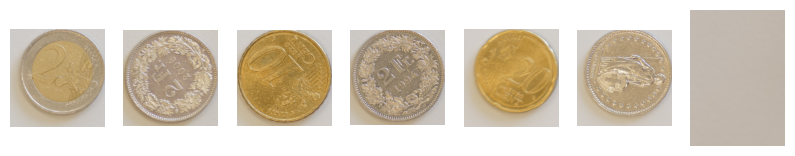

In [76]:
# Crop the bounding boxes from the images
def crop_bounding_boxes(img_original, contours):
    '''
    Takes in an image with multiple coins and its contours that represent the coins.
    Outputs a list of cropped images.
    '''

    img = img_original.copy()
    cropped_images = []

    for cntr in contours:
        area = cv.contourArea(cntr)

        # Check if contour is big enough
        if area < 70000 or area > 700000:
            continue

        x, y, w, h = cv.boundingRect(cntr)
        cropped_images.append(img[y:y+h, x:x+w])

    return cropped_images

# Apply filters and 
neutral_bg_sample_filtered, contours = get_contours(neutral_bg_sample)

# Remember to pass in the original image, otherwise we get the red bounding boxes as well
cropped_coins = crop_bounding_boxes(neutral_bg_sample, contours)

# Plot the cropped coins
plt.figure(figsize=(10, 10))
for i, coin in enumerate(cropped_coins):
    plt.subplot(1, len(cropped_coins), i+1)
    plt.imshow(coin)
    plt.axis('off')
plt.show()

# Save the cropped coins
for i, coin in enumerate(cropped_coins):
    cv.imwrite(f"coin_{i}.jpg", cv.cvtColor(coin, cv.COLOR_RGB2BGR))



In [77]:
path_to_test = "data/test/"

for test_image in os.listdir(path_to_test):
    test_image_path = os.path.join(path_to_test, test_image)
    loaded_image = cv.imread(test_image_path)
    loaded_image = cv.cvtColor(loaded_image, cv.COLOR_BGR2RGB) 
    filtered_image, contours = get_contours(loaded_image)
    cropped_coins = crop_bounding_boxes(filtered_image, contours)
    cropped_coins_folder_path = f"output/{test_image}"
    cropped_coins_folder_path = cropped_coins_folder_path.replace(".JPG", "")
    os.mkdir(cropped_coins_folder_path)
    for i, coin in enumerate(cropped_coins):
        path_to_save = os.path.join(cropped_coins_folder_path, f"coin_{i}.jpg")
        cv.imwrite(path_to_save, cv.cvtColor(coin, cv.COLOR_RGB2BGR))

FileExistsError: [Errno 17] File exists: 'output/L0000106'